In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit

In [116]:
df = pd.read_csv("Testapp\SwimDataTop50.csv")

In [117]:
# Function to parse time strings with variable formats
def parse_custom_time(time_str):
    time_parts_count = len(str(time_str).split(":"))
    format_map = {1: '00:00:{}', 2: '00:{}', 3: '{}'}

    if time_parts_count in format_map:
        return pd.to_timedelta(format_map[time_parts_count].format(time_str))
    else:
        raise ValueError(f'Invalid time format: {time_str}')

# Convert 'time' column to timedelta 
df['time'] = df['time'].apply(parse_custom_time)

# Calculate 'time_seconds' and 'speed' columns
df.loc[:, 'time_seconds'] = df['time'].dt.total_seconds()
df.loc[:, 'speed'] = df['distance'] / df['time_seconds']

df.drop_duplicates(subset=['surname', 'firstname', 'distance', 'technique', 'track length'], keep='first', inplace=True)

# Group the data by 'surname', 'firstname', 'track length', 'technique'
grouped_data = df.groupby(['surname', 'firstname', 'track length', 'technique'])
grouped_data.size()

surname    firstname  track length  technique    
ARMSTRONG  Hunter     25            Freistil         2
                                    Rücken           2
                      50            Freistil         3
                                    Rücken           3
                                    Schmetterling    1
                                                    ..
ZHAO       Jing       25            Lagen            2
                                    Rücken           3
                      50            Freistil         1
                                    Lagen            2
                                    Rücken           3
Length: 516, dtype: int64

In [125]:
def fit_rational_function(x, a, b, c, d):
    return d / (a * x + b) + c

In [5]:
#constants
DISTANCE_200 = 200
TRACK_LENGTHS = [25, 50]
TECHNIQUES = ['F', 'R', 'B', 'S', 'L']
TECHNIQUE_MAP = {
    'F': 'Freistil',
    'R': 'Rücken',
    'B': 'Brust',
    'S': 'Schmetterling',
    'L': 'Lagen'
}

In [126]:
# Function to filter data for a specific swimmer and plot the rational function fit
def plot_rational_function_for_swimmer(df, firstname, lastname, track_length, technique, isAbsolute=False):

    # Validate parameters
    if not firstname or not lastname or not track_length or not technique:
        raise ValueError('Invalid request. Please provide all parameters.')
    elif technique not in TECHNIQUES:
        raise ValueError('Invalid request. Technique must be one of F, R, B, S, L.')
    elif track_length not in TRACK_LENGTHS:
        raise ValueError('Invalid request. Track length must be one of 25, 50.')

    lastname = lastname.upper()
    
    # Lists to store predicted and measured values
    measured_values = {}
    predicted_values = {}

    # Map the technique
    technique = TECHNIQUE_MAP[technique]

    # Filter the DataFrame based on the provided parameters
    filtered_df = df[(df['firstname'] == firstname) & (df['surname'] == lastname) & (df['track length'] == int(track_length)) & (df['technique'] == technique)]

   # If no data found, return an error message
    if filtered_df.empty:
        raise ValueError(f'No data found for {firstname} {lastname}.')
    elif len(filtered_df) < 3:
        raise ValueError(f'Not enough data found for {firstname} {lastname}.')
    
    if not isAbsolute:
        # Check if 200m distance is present in the filtered data
        if DISTANCE_200 in filtered_df['distance'].unique():
            # If 200m distance is present, use the speed value for division
            divisor = filtered_df[filtered_df['distance'] == DISTANCE_200]['speed'].values[0]
        else:
            # If 200m distance is not present, find the closest distance and use its speed value for division
            closest_distance_index = (filtered_df['distance'] - 200).abs().argsort().sort_values()[:1].index
            print(closest_distance_index)
            divisor = filtered_df.loc[closest_distance_index, 'speed'].values[0]

        # Calculation for relative speed to 200m
        filtered_df.loc[:,'speed'] = filtered_df['speed'] / divisor


    # Fit a rational function to the filtered data
    try:
        params, covariance = curve_fit(fit_rational_function, filtered_df['distance'], filtered_df['speed'], method="dogbox",maxfev=500000)
    except RuntimeError:
        raise RuntimeError('Curve fitting failed.')
        

    x_range = np.linspace(0, 2000, 200)
    y_pred = fit_rational_function(x_range, *params)

    for X, Y in zip(x_range, y_pred):
        predicted_values[X] = Y

    for distance, speed in zip(filtered_df['distance'], filtered_df['speed']):
        measured_values[distance] = speed

    # Create a JSON response containing predicted and measured values
    data = {
        "pred_values": predicted_values,
        "mes_values": measured_values
    }
    return data


C:\Users\lukas\AppData\Local\Temp\ipykernel_16548\2381225853.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'speed'] = filtered_df['speed'] / divisor


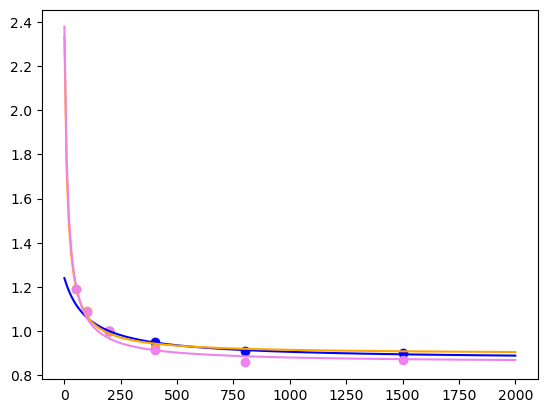

In [133]:
Endurance = plot_rational_function_for_swimmer(df, firstname='Yang', lastname='Sun', track_length=50, technique='F')
plt.plot(Endurance['pred_values'].keys(), Endurance['pred_values'].values(), color='blue', label='Prediction')
plt.scatter(Endurance['mes_values'].keys(), Endurance['mes_values'].values(), color='blue', label='Measurement')

"""yannick = plot_rational_function_for_swimmer(df, firstname='Yannick', lastname='Knab', track_length=50, technique='F')
plt.plot(yannick['pred_values'].keys(), yannick['pred_values'].values(), color='green', label='Prediction')
plt.scatter(yannick['mes_values'].keys(), yannick['mes_values'].values(), color='green', label='Measurement')
"""
"""kilian = plot_rational_function_for_swimmer(df, firstname='Kilian', lastname='Roppel', track_length=50, technique='F')
plt.plot(kilian['pred_values'].keys(), kilian['pred_values'].values(), color='red', label='Prediction')
plt.scatter(kilian['mes_values'].keys(), kilian['mes_values'].values(), color='red', label='Measurement')
"""
severin = plot_rational_function_for_swimmer(df, firstname='Severin', lastname='Oberli', track_length=50, technique='F')
plt.plot(severin['pred_values'].keys(), severin['pred_values'].values(), color='orange', label='Prediction')
plt.scatter(severin['mes_values'].keys(), severin['mes_values'].values(), color='orange', label='Measurement')

xenia = plot_rational_function_for_swimmer(df, firstname='Xenia', lastname='Blumin', track_length=50, technique='F')
plt.plot(xenia['pred_values'].keys(), xenia['pred_values'].values(), color='violet', label='Prediction')
plt.scatter(xenia['mes_values'].keys(), xenia['mes_values'].values(), color='violet', label='Measurement')